## Import Libraries and Load Data

In [1]:
import modules.preprocessing as prep
import modules.evaluation as ev
import pandas as pd
import os

In [2]:
# Load in datasets and create periodic dataframes
base_dfs = [prep.load_dataset(f'../data/SN_{freq}_tot_V2.0.csv') for freq in ['d', 'm', 'y']]
periodic_dfs = [x[0] for x in [prep.create_periodic_dataframe(df) for df in base_dfs]]
periodic_dfs[-1] = periodic_dfs[-1][periodic_dfs[-1].ds >= pd.to_datetime('1750-01-01')].reset_index(drop = True)

In [3]:
# Define file names
sampling_frequencies = ['daily', 'monthly', 'yearly']
daily_names = ['base_daily', 'daily__s-11y20f__g-linear__cp-50__cn-80']
monthly_names = ['base_monthly', 'monthly__s-11y160f__g-linear__cp-80__cn-90']
yearly_names = ['base_yearly', 'yearly__s-11y360f__g-linear__cp-80__cn-90']
model_names = daily_names + monthly_names + yearly_names

# Define file paths
model_base_paths = [os.path.join('..', 'models', x) for x in sampling_frequencies]
forecast_base_paths = [os.path.join('..', 'forecasts', x) for x in sampling_frequencies]
model_paths = [os.path.join(model_base_paths[i // 2], model_names[i] + '.pickle')
               for i in range(len(model_names))]
forecast_paths = [os.path.join(forecast_base_paths[i // 2], model_names[i] + '.pickle')
                  for i in range(len(model_names))]

# Load in models and forecasts
models = [ev.load_pickle(m) for m in model_paths]
forecasts = [ev.load_pickle(m) for m in forecast_paths]

Pickled object at ../models/daily/base_daily.pickle loaded successfully.
Pickled object at ../models/daily/daily__s-11y20f__g-linear__cp-50__cn-80.pickle loaded successfully.
Pickled object at ../models/monthly/base_monthly.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../models/yearly/base_yearly.pickle loaded successfully.
Pickled object at ../models/yearly/yearly__s-11y360f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../forecasts/daily/base_daily.pickle loaded successfully.
Pickled object at ../forecasts/daily/daily__s-11y20f__g-linear__cp-50__cn-80.pickle loaded successfully.
Pickled object at ../forecasts/monthly/base_monthly.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../forecasts/yearly/base_yearly.pickle loaded successfully.
Pickled obje

## Model Evaluation

Even though the yearly and monthly models are able to attain slightly lower MAE values, the models themselves are significantly more complex than the daily model. The monthly and yearly models use 8x and 18x the number of partial Fourier terms as the daily model, respectively.

The MAPE of the daily model is significantly lower than that of the monthly and yearly models, indicating that once the magnitude of the data points is taken into account, the daily model performs much better. The monthly model performs worst by this metric, suggesting that monthly sampling of the data is the least effective method of aggregating the sunspot data.

The daily model also attains the best $R^2$ value, indicating that the model fits the data better than the monthly and yearly models. The yearly model performs the worst along this metric, most likely due to the relative lack of data when resampled at this frequency. The yearly model contains only 272 data points compared to the 3,280 and 74,630 data points of the monthly and daily models, respectively. With such sparseness of data, there are not as many points to use to create an accurate regression.

Because the daily model attains the best MAPE and $R^2$ scores and similar MAE scores compared to the monthly and yearly models while being much less complex, the daily model, along with daily sampling of the data, would seem to be the best method for modeling sunspot occurrences.

In [4]:
# Create titles
model_titles = [
    'Base Daily Untuned, G = Linear, CP = 0.05, CN = 25',
    'Daily Fully Tuned, S = 11y, 20f, G = Linear, CP = 0.5, CN = 80',
    'Base Monthly Untuned, G = Linear, CP = 0.05, CN = 25',
    'Monthly Fully Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 90',
    'Base Yearly Untuned, G = Linear, CP = 0.05, CN = 25',
    'Yearly Fully Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 90'
]

# Calculate model metrics
obs_preds_names = [(periodic_dfs[i // 2], forecasts[i][0], model_titles[i]) for i in range(len(forecasts))]
ev.multi_model_errors(obs_preds_names).sort_values('r2')

,mae,mape,r2
"Base Yearly Untuned, G = Linear, CP = 0.05, CN = 25",51.935590,2.291910,0.000157
"Base Monthly Untuned, G = Linear, CP = 0.05, CN = 25",53.337921,4.834923,0.064501
"Base Daily Untuned, G = Linear, CP = 0.05, CN = 25",56.713345,1.132964,0.149900
"Yearly Fully Tuned, S = 11y, 360f, G = Linear, CP = 0.8, CN = 90",33.692217,1.198048,0.538886
"Monthly Fully Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 90",33.963486,2.096062,0.579968
"Daily Fully Tuned, S = 11y, 20f, G = Linear, CP = 0.5, CN = 80",34.964004,0.621157,0.613232


Note that the observed data points below are the daily frequency data points.

The yearly model struggles to modulate the magnitude of the cycles, due to working with a heavy loss of information by using mean yearly values. It also appears to have a very gentle trend compared to the daily model. The monthly model performs similarly, with a little more modulation in cycle-magnitude and trend, as expected since the loss of information is lower when using mean monthly values. Interestingly, both the monthly and yearly models have periods of being ahead of or lagging behind the observed values.

The daily model fits the observed data fairly well, although it is not quite able to capture the full maximum of each cycle peak. This is almost certainly due to the model being influenced by the zero and missing values (assigned a value of -1) which are pulling the model downwards. Regardless, the daily model is the smoothest (due to the significantly lower Fourier order), while appearing to capture much more information.

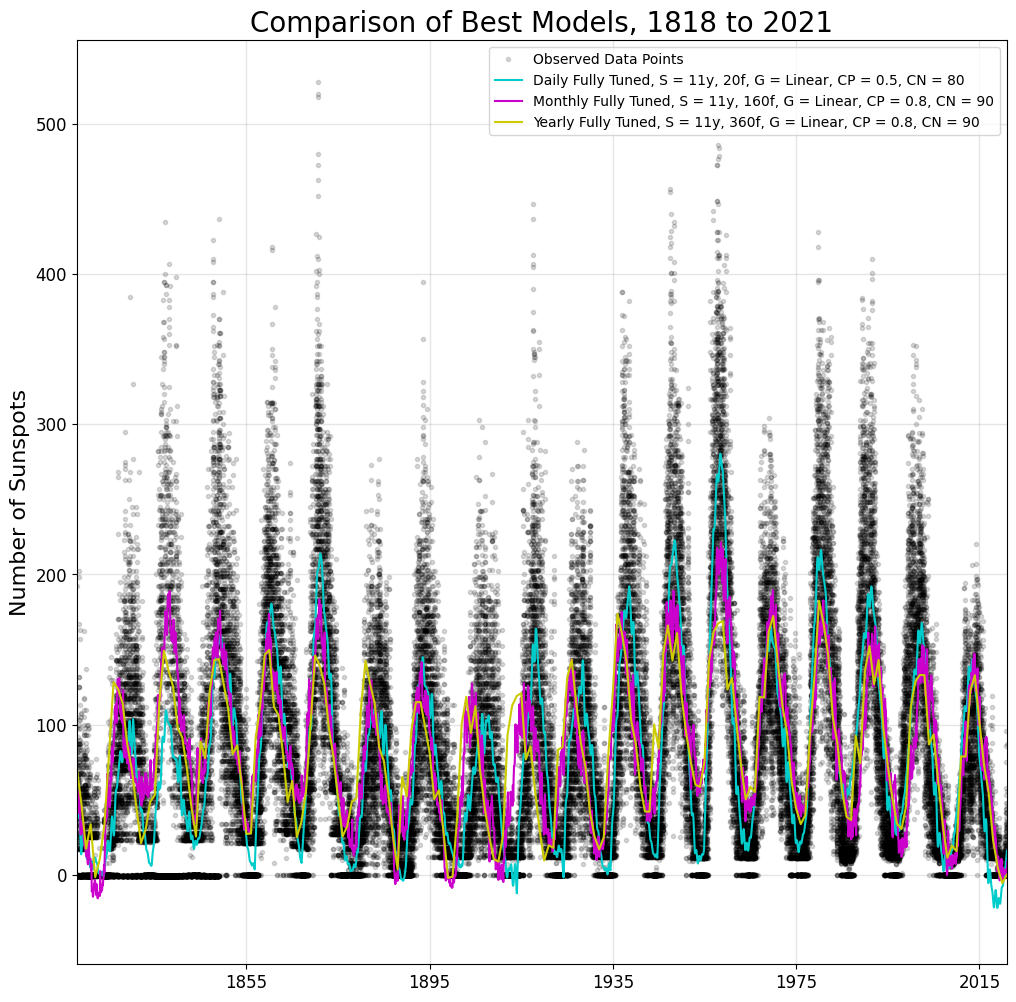

In [5]:
# Define plotting parameters
plot_params = {
    'models': models[1::2], 'model_names': model_titles[1::2], 'forecasts': forecasts[1::2],
    'prior_periods': None, 'prediction_periods': None,
    'titles': [
        'Comparison of Best Models, 1818 to 2021',
    ]}

# Plot to model and restrict timeline to where all datasets overlap
ax = ev.plot_model_comparisons(**plot_params);
ax.set_xlim([pd.to_datetime('1818-01-01'), pd.to_datetime('2021-01-01')]);